# NYC Rent Price Calculator

## Background

NYC rental prices are influenced by a lot of factors. In order to properly price a rental unit, you must understand the rental price of similar units. However, almost no two units are the same, hence to price a specific unit, you must find some way to combine prices from different units that have similar characteristics. This can be extremely time consuming if you are doing research online without any tools. This calculator provides a way to quickly determine a good way to price a rental unit.

Rental units are often marketed via online listings. You may also save time determining what key words are important to put in a listing in order to increase rental price or chance of renting out a unit.

Since rental prices in NYC are extremely high, but at the same time low margin comapred to other locales, it is essential to set a good rental price for a unit. Setting the wrong rental price by even 10% may result in thousands or tens of thousands of lost rental income per year.

## Objective

We will provide a model that will give the rental price for an apartment given various known attributes of an apartment. This machine learning model will be trained on data of rental units around NYC.

## Gather Data

We gather data about rental prices around NYC. Renthop is a site that lists rental properties. They have provided some data from 2016 of rented apartments, so for this investigation we use this data to train our model.
The data is derived from https://www.kaggle.com/competitions/two-sigma-connect-rental-listing-inquiries/data, but we use a variant that has been converted to a csv for easier ingestion.

Some concerns about this data:
- This may be a biased list of rental data. Properties listed on renthop may not fully represent the NYC market. However, renthop is a large site with many listings, so this should be fairly representative of the general NYC rental market.
- This data is from 2016. It is extremely difficult/expensive to gather recent NYC rental data. We may try to scale the data to 2022 levels.
- This data is apartments that are listed, not apartments that have been rented. This model will hence tell you how to fall in the middle of apartments listed. It will be up to you to determine where you want to fall in that distribution (do you want to try to price higher or lower than the market).

NYC rental price data is very valuable since it can be used for profit in the high value real estate market. Hence, it is difficult to obtain a lot of clean data. I will work with this data set as its limitations are relatively small.

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# making data frame
rent_df = pd.read_csv("data/renthopNYC.csv")

## Investigating The Data

We take a look at the shape of the data and what columns are available and look at some sample rows.

In [3]:
rent_df.shape

(49352, 34)

In [4]:
rent_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49352 entries, 0 to 49351
Data columns (total 34 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   bathrooms             49352 non-null  float64
 1   bedrooms              49352 non-null  int64  
 2   created               49352 non-null  object 
 3   description           47906 non-null  object 
 4   display_address       49217 non-null  object 
 5   latitude              49352 non-null  float64
 6   longitude             49352 non-null  float64
 7   price                 49352 non-null  int64  
 8   street_address        49342 non-null  object 
 9   interest_level        49352 non-null  object 
 10  elevator              49352 non-null  int64  
 11  cats_allowed          49352 non-null  int64  
 12  hardwood_floors       49352 non-null  int64  
 13  dogs_allowed          49352 non-null  int64  
 14  doorman               49352 non-null  int64  
 15  dishwasher         

In [5]:
rent_df.head()

,bathrooms,bedrooms,created,description,display_address,latitude,longitude,price,street_address,interest_level,...,high_speed_internet,balcony,swimming_pool,new_construction,terrace,exclusive,loft,garden_patio,wheelchair_access,common_outdoor_space
0,1.5,3,6/24/2016 7:54,A Brand New 3 Bedroom 1.5 bath ApartmentEnjoy ...,Metropolitan Avenue,40.7145,-73.9425,3000,792 Metropolitan Avenue,medium,...,0,0,0,0,0,0,0,0,0,0
1,1.0,2,6/12/2016 12:19,,Columbus Avenue,40.7947,-73.9667,5465,808 Columbus Avenue,low,...,0,0,0,0,0,0,0,0,0,0
2,1.0,1,4/17/2016 3:26,"Top Top West Village location, beautiful Pre-w...",W 13 Street,40.7388,-74.0018,2850,241 W 13 Street,high,...,0,0,0,0,0,0,0,0,0,0
3,1.0,1,4/18/2016 2:22,Building Amenities - Garage - Garden - fitness...,East 49th Street,40.7539,-73.9677,3275,333 East 49th Street,low,...,0,0,0,0,0,0,0,0,0,0
4,1.0,4,4/28/2016 1:32,Beautifully renovated 3 bedroom flex 4 bedroom...,West 143rd Street,40.8241,-73.9493,3350,500 West 143rd Street,low,...,0,0,0,0,0,0,0,0,0,0


For each of the columns, let's take a look at the different values in the column and see if there is a good distribution of the data.

In [6]:
rent_df["price"].value_counts()

2500     1106
3200      881
3000      840
2700      777
2400      772
         ... 
3394        1
5473        1
2391        1
2493        1
10650       1
Name: price, Length: 2808, dtype: int64

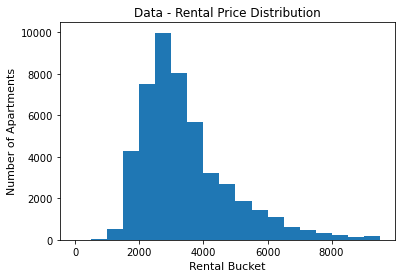

In [7]:
plt.figure()
plt.hist(rent_df['price'],  bins = range(0, 10000, 500))
plt.title('Data - Rental Price Distribution',fontsize=12)
plt.xlabel('Rental Bucket',fontsize=11)
plt.ylabel('Number of Apartments',fontsize=11)
plt.show()

We see that price is not normally distributed, most units are around $3000 per month, but there is a long tail above that.

In [8]:
rent_df["elevator"].value_counts()

1    25916
0    23436
Name: elevator, dtype: int64

In [9]:
rent_df["hardwood_floors"].value_counts()

0    25823
1    23529
Name: hardwood_floors, dtype: int64

In [10]:
rent_df["cats_allowed"].value_counts()

0    25812
1    23540
Name: cats_allowed, dtype: int64

In [11]:
rent_df["dogs_allowed"].value_counts()

0    27317
1    22035
Name: dogs_allowed, dtype: int64

In [12]:
rent_df["doorman"].value_counts()

0    28383
1    20969
Name: doorman, dtype: int64

In [13]:
rent_df["hardwood_floors"].value_counts()

0    25823
1    23529
Name: hardwood_floors, dtype: int64

In [14]:
rent_df["dishwasher"].value_counts()

0    28922
1    20430
Name: dishwasher, dtype: int64

In [15]:
rent_df["no_fee"].value_counts()

0    31290
1    18062
Name: no_fee, dtype: int64

No Fee may not be an option for a rental calculator, but we may leave it in the model for now

In [16]:
rent_df["roof_deck"].value_counts()

0    42797
1     6555
Name: roof_deck, dtype: int64

In [17]:
rent_df["outdoor_space"].value_counts()

0    42508
1     6844
Name: outdoor_space, dtype: int64

In [18]:
rent_df["dining_room"].value_counts()

0    44215
1     5137
Name: dining_room, dtype: int64

In [19]:
rent_df["high_speed_internet"].value_counts()

0    45049
1     4303
Name: high_speed_internet, dtype: int64

This is data seems unreliable - most building in NYC have high speed internet

In [20]:
rent_df["balcony"].value_counts()

0    46357
1     2995
Name: balcony, dtype: int64

In [21]:
rent_df["swimming_pool"].value_counts()

0    46620
1     2732
Name: swimming_pool, dtype: int64

In [22]:
rent_df["new_construction"].value_counts()

0    46793
1     2559
Name: new_construction, dtype: int64

In [23]:
rent_df["terrace"].value_counts()

0    47040
1     2312
Name: terrace, dtype: int64

In [24]:
rent_df["exclusive"].value_counts()

0    47184
1     2168
Name: exclusive, dtype: int64

In [25]:
rent_df["loft"].value_counts()

0    47249
1     2103
Name: loft, dtype: int64

In [26]:
rent_df["garden_patio"].value_counts()

0    47409
1     1943
Name: garden_patio, dtype: int64

In [27]:
rent_df["wheelchair_access"].value_counts()

0    47994
1     1358
Name: wheelchair_access, dtype: int64

In [28]:
rent_df["common_outdoor_space"].value_counts()

0    48059
1     1293
Name: common_outdoor_space, dtype: int64

In [29]:
rent_df["laundry_in_unit"].value_counts()

0    40614
1     8738
Name: laundry_in_unit, dtype: int64

In [30]:
rent_df["laundry_in_building"].value_counts()

0    46759
1     2593
Name: laundry_in_building, dtype: int64

We see that laundry in the building is pretty rare, so we may not be able to get a good signal from this data set. From experience, this may also be inaccurate or poorly named since it is lower than laundry in unit.

In [31]:
rent_df["fitness_center"].value_counts()

0    36100
1    13252
Name: fitness_center, dtype: int64

In [32]:
rent_df["pre-war"].value_counts()

0    40201
1     9151
Name: pre-war, dtype: int64

In [33]:
rent_df["bathrooms"].value_counts()

1.0     39422
2.0      7660
3.0       745
1.5       645
0.0       313
2.5       277
4.0       159
3.5        70
4.5        29
5.0        20
5.5         5
6.0         4
10.0        1
6.5         1
7.0         1
Name: bathrooms, dtype: int64

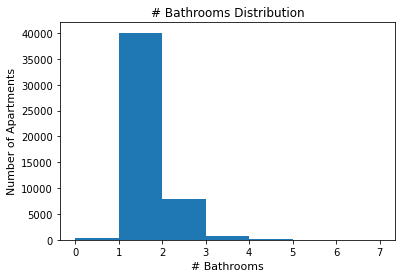

In [34]:
plt.figure()
plt.hist(rent_df['bathrooms'],  bins = range(0, 8, 1))
plt.title('# Bathrooms Distribution',fontsize=12)
plt.xlabel('# Bathrooms',fontsize=11)
plt.ylabel('Number of Apartments',fontsize=11)
plt.show()

In [35]:
rent_df["bedrooms"].value_counts()

1    15752
2    14623
0     9475
3     7276
4     1929
5      247
6       46
7        2
8        2
Name: bedrooms, dtype: int64

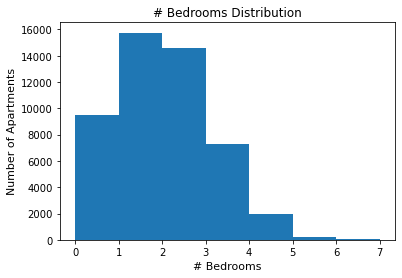

In [36]:
plt.figure()
plt.hist(rent_df['bedrooms'],  bins = range(0, 8, 1))
plt.title('# Bedrooms Distribution',fontsize=12)
plt.xlabel('# Bedrooms',fontsize=11)
plt.ylabel('Number of Apartments',fontsize=11)
plt.show()

We see that there are few apartments with 4 or more bedrooms, so the model may not work well above 4 bedrooms

## Cleaning the Data

Some of the columns do not lend themselves to be used by a machine learning algorithm. We investigate these columns and convert them into data that can be better used for the model

### Check Overall Data Quality

First, let us check for any duplicated rows.

In [37]:
rent_df.duplicated().sum()

39

There are limited duplicated rows, so let us drop these in case they are incorrect data. Out of all the rows, this represents a small portion, so it is likely we can still trust the rest of the data.

In [38]:
rent_df = rent_df.drop_duplicates()

Let's investigate also how much of the data is empty

In [39]:
rent_df.isna().sum()

bathrooms                  0
bedrooms                   0
created                    0
description             1444
display_address          135
latitude                   0
longitude                  0
price                      0
street_address            10
interest_level             0
elevator                   0
cats_allowed               0
hardwood_floors            0
dogs_allowed               0
doorman                    0
dishwasher                 0
no_fee                     0
laundry_in_building        0
fitness_center             0
pre-war                    0
laundry_in_unit            0
roof_deck                  0
outdoor_space              0
dining_room                0
high_speed_internet        0
balcony                    0
swimming_pool              0
new_construction           0
terrace                    0
exclusive                  0
loft                       0
garden_patio               0
wheelchair_access          0
common_outdoor_space       0
dtype: int64

In [40]:
rent_df.isna().sum()/rent_df.shape[0]*100.0

bathrooms               0.000000
bedrooms                0.000000
created                 0.000000
description             2.928234
display_address         0.273761
latitude                0.000000
longitude               0.000000
price                   0.000000
street_address          0.020279
interest_level          0.000000
elevator                0.000000
cats_allowed            0.000000
hardwood_floors         0.000000
dogs_allowed            0.000000
doorman                 0.000000
dishwasher              0.000000
no_fee                  0.000000
laundry_in_building     0.000000
fitness_center          0.000000
pre-war                 0.000000
laundry_in_unit         0.000000
roof_deck               0.000000
outdoor_space           0.000000
dining_room             0.000000
high_speed_internet     0.000000
balcony                 0.000000
swimming_pool           0.000000
new_construction        0.000000
terrace                 0.000000
exclusive               0.000000
loft      

It appears that most data is available. Description is not available for some apartments, but that should be fine. We are missing address for a few, but that will not be used since it is free form text. Hence we don't need to do anything here

### Created Date

Created date can be converted into the year and day of the year that the rental was created. From experience, it is believed that NYC rental prices fluctuate by day of the year, so we want to separate out the day of the year from the year itself. We also include the year and days since epoch. We will alter scale these values.

In [41]:
#Converting the review date to the day of the year
rent_df["created_date"] = pd.to_datetime(rent_df["created"])
rent_df["created_epoch_secs"] = (rent_df["created_date"] - pd.Timestamp("1970-01-01")) // pd.Timedelta('1s')
rent_df["created_year"] = rent_df["created_date"].dt.year
rent_df["created_day"] = rent_df["created_date"].dt.dayofyear

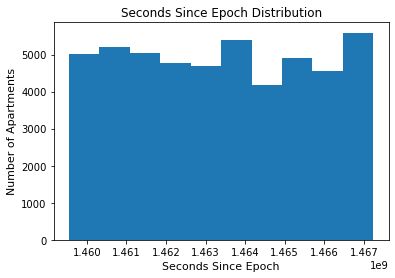

In [42]:
plt.figure()
plt.hist(rent_df['created_epoch_secs'])
plt.title('Seconds Since Epoch Distribution',fontsize=12)
plt.xlabel('Seconds Since Epoch',fontsize=11)
plt.ylabel('Number of Apartments',fontsize=11)
plt.show()

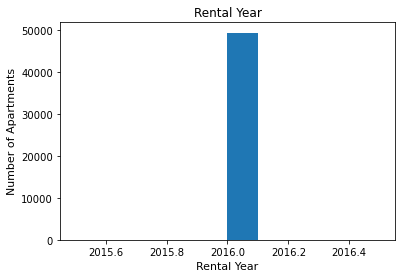

In [43]:
plt.figure()
plt.hist(rent_df['created_year'])
plt.title('Rental Year',fontsize=12)
plt.xlabel('Rental Year',fontsize=11)
plt.ylabel('Number of Apartments',fontsize=11)
plt.show()

We see this data is only for the year 2016

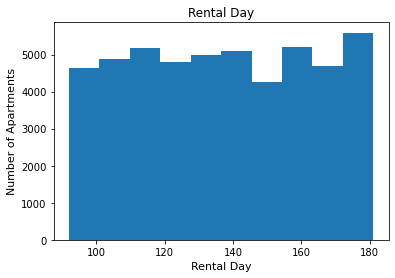

In [44]:
plt.figure()
plt.hist(rent_df['created_day'])
plt.title('Rental Day',fontsize=12)
plt.xlabel('Rental Day',fontsize=11)
plt.ylabel('Number of Apartments',fontsize=11)
plt.show()

We see that the data only includes rentals in a few months of the year. This may be a problem because rental prices in NYC fluctuate by month. Unfortunately, rental data in NYC is very difficult to attain, so we will do the best with this information.

Across the months, the rental data is fairly uniform, so we don't see any selection bias on this factor.

In [45]:
# Check all distinct values
rent_df["created"].value_counts()

6/14/2016 2:21     21
6/1/2016 6:07      15
6/14/2016 15:57    14
6/14/2016 15:25    14
5/24/2016 5:51     14
                   ..
4/13/2016 1:29      1
4/2/2016 17:07      1
4/19/2016 4:02      1
4/25/2016 2:26      1
4/4/2016 18:22      1
Name: created, Length: 21213, dtype: int64

We see no dates are overly represented, so there is likely not some strange outliers or bias in the data.

In [46]:
rent_df['created'] = pd.to_datetime(rent_df['created'])


Let's investigate all our columns and see if they are suitable for a machine learning model

In [47]:
rent_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 49313 entries, 0 to 49351
Data columns (total 38 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   bathrooms             49313 non-null  float64       
 1   bedrooms              49313 non-null  int64         
 2   created               49313 non-null  datetime64[ns]
 3   description           47869 non-null  object        
 4   display_address       49178 non-null  object        
 5   latitude              49313 non-null  float64       
 6   longitude             49313 non-null  float64       
 7   price                 49313 non-null  int64         
 8   street_address        49303 non-null  object        
 9   interest_level        49313 non-null  object        
 10  elevator              49313 non-null  int64         
 11  cats_allowed          49313 non-null  int64         
 12  hardwood_floors       49313 non-null  int64         
 13  dogs_allowed    

The remaining fields that are not suitable for machine learning are:
- created: we have created new fields that are more suitable, so we can drop this one.
- description: we will handle this later. In order to create a bag of words and do exploratory data analysis, we should first split the data into train and test sets, so we will only handle this field after that has been done and the rest of the data is cleaned up.
- display address: it is unlikely we get any useful information from this, so we may drop it
- street address: it is unlikely we get any useful information from this, so we may drop it
- interest level: this is data that will not be available to people seeking to calculate their rent price, so we will remove this. This is data that was added by renthop after the apartment was listed and information about it was determined.
- created_date: this is similar to created and can be dropped

Let's drop these fields (besides description).

In [48]:
rent_df = rent_df.drop(columns=["created", "display_address", "street_address", "interest_level", "created_date"])

In [49]:
rent_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 49313 entries, 0 to 49351
Data columns (total 33 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   bathrooms             49313 non-null  float64
 1   bedrooms              49313 non-null  int64  
 2   description           47869 non-null  object 
 3   latitude              49313 non-null  float64
 4   longitude             49313 non-null  float64
 5   price                 49313 non-null  int64  
 6   elevator              49313 non-null  int64  
 7   cats_allowed          49313 non-null  int64  
 8   hardwood_floors       49313 non-null  int64  
 9   dogs_allowed          49313 non-null  int64  
 10  doorman               49313 non-null  int64  
 11  dishwasher            49313 non-null  int64  
 12  no_fee                49313 non-null  int64  
 13  laundry_in_building   49313 non-null  int64  
 14  fitness_center        49313 non-null  int64  
 15  pre-war            

For description, let's clean up the empty fields to be an emtpy string

In [124]:
rent_df["description"] = rent_df["description"].fillna("")

In [125]:
rent_df.isna().sum()

bathrooms                   0
bedrooms                    0
description                 0
latitude                    0
longitude                   0
                           ..
zipcode_13166               0
zipcode_19355               0
min_dist_to_subway          0
very_far_from_subway        0
subway_distance_max_4000    0
Length: 233, dtype: int64

We will also clean longitude and latitude in the next section when we investigate zip codes

## Adding Features

We want to add a few more features to be able to get a better model.

The existing data has a lot of information about the features of the apartment. However, one of the biggest factors in NYC rental pricing is location. Longitude and Latitude will be difficult for a machine learning algorithm to train on, so we may introduce a few more features related to location. We will look at two that we may, from experience, think impacts NYC rental pricing:
- zip code: this will tell us roughly what neighborhood of NYC the rental unit is in. Some neighborhoods are more expensive than others.
- distance to subway: this will tell us how close an apartment is to public transit which will make it more desirable due to being an easier commute to work.

### Zip Code

We will use outside libraries and data and APIs to get the zip code given a longitude and latitude.

First, let's see if longitude and latitude are accurate. NYC is around -74 lng, 41 lat (Times Square), so let's check around 3 degrees in either direction if there are any rows that are not in NYC

In [51]:
rent_df[(rent_df['latitude'] < 38) | (rent_df['latitude'] > 44) | (rent_df['longitude'] < -77) | (rent_df['longitude'] > -71)]

,bathrooms,bedrooms,description,latitude,longitude,price,elevator,cats_allowed,hardwood_floors,dogs_allowed,...,new_construction,terrace,exclusive,loft,garden_patio,wheelchair_access,common_outdoor_space,created_epoch_secs,created_year,created_day
2150,1.0,0,NEWLY RENOVATED BEAUTIFUL SPACIOUS HUGE STUDIO...,39.8395,-86.1527,2650,1,0,0,0,...,0,0,0,0,0,0,0,1460772600,2016,107
2787,5.0,6,***NO BROKER FEE***<BR><BR>Situated on a gorge...,0.0000,0.0000,9995,0,1,0,1,...,0,1,0,0,1,0,0,1460945640,2016,109
6546,2.0,2,T_208-421-1596<br />kagglemanager@rent...,42.2019,-70.9846,2541,0,1,0,1,...,0,0,0,0,0,0,0,1461213360,2016,112
12387,1.0,0,,44.6038,-75.1773,1350,0,0,0,0,...,0,0,0,0,0,0,1,1466637420,2016,174
14104,1.0,1,Gorgeous one bedroom in Sunset Park-Private en...,0.0000,0.0000,1750,0,0,0,0,...,0,0,0,0,0,0,0,1464733560,2016,152
21715,1.0,1,Big 2 bedroom in clean and quite multi family ...,0.0000,0.0000,1725,0,1,0,0,...,0,0,0,0,0,0,0,1464811140,2016,153
22437,1.0,1,Lenox Farms Apartments & Town Homes of...,42.2019,-70.9846,2140,0,1,0,1,...,0,0,0,0,0,0,0,1466051280,2016,168
22471,1.0,2,Flatiron Duplex!At the intersection of Flatiro...,0.0000,0.0000,4395,0,1,0,1,...,0,0,0,0,0,0,0,1466091480,2016,168
22767,1.0,1,NO FEE 1 bedroom - Great Elevator - Laundry B...,34.0126,-118.2710,2425,1,0,1,0,...,0,0,0,0,0,0,0,1466129400,2016,169
23283,2.0,2,Lenox Farms Apartments & Town Homes of...,42.2019,-70.9846,2709,0,1,0,1,...,0,0,0,0,0,0,0,1466746080,2016,176


We see that there are a few listings that either have no latitude longitude or are outside of NYC (manual investigation shows these are in towns near but not inside NYC).

This is a small amount, so let us drop these fields to clean the data.

In [52]:
rent_df = rent_df[(rent_df['latitude'] > 38) & (rent_df['latitude'] < 44) & (rent_df['longitude'] > -77) & (rent_df['longitude'] < -71)]

We will try the geopy python library. Geopy is a library which then hits an online API to get geo information. They have a reverse function that lets users look up information given a longitude and latitude.

In [53]:
import geopy

In [54]:
geolocator = geopy.Nominatim(user_agent="long_lat_to_zip_code")

In [55]:
def geopy_get_zip_code(lat, lng):
    location = geolocator.reverse("{}, {}".format(lat,lng))
    return location.raw['address']['postcode']



tqdm will let us monitor an apply function from pandas to see how long it will take

In [56]:
from tqdm import tqdm
tqdm.pandas()

In [57]:
# geopy is too slow, but let's take a look at if we tried for the first 5
rent_df_head_zip_test = rent_df.head(5).progress_apply(lambda row: geopy_get_zip_code(row['latitude'], row['longitude']), axis=1)

rent_df_head_zip_test

100%|██████████| 5/5 [00:02<00:00,  2.09it/s]


0    11211
1    10025
2    10011
3    10022
4    10031
dtype: object

If we had more time, we may use geopy to get the zip codes of each row. However, geopy has a terms of service that restricts usage of the API at over 1 data point per second and tries to prevent usage for large data sets. So let's only use geopy when we need to.

In [58]:
# Don't run this because it will take 7 hours and may violate geopy terms of service
# rent_df['zipcode'] = rent_df.progress_apply(lambda row: geopy_get_zip_code(row['latitude'], row['longitude']), axis=1)

uszipcode is a python library that downloads data about various zip codes and then calculates the zip code information locally.

In [59]:
# Make sure to install 0.2.6, 1.0.1 is not compatible with Python 3.9+
from uszipcode import SearchEngine

This will download the zip code data from the library. Let's investigate the first 5 and see how accurate it is. Through experimentation, we see that sometimes this library does not return a zip code. This is pretty rare, so in those cases we can use geopy and it will not violate their ToS since this will only be done very rarely.

In [60]:
zip_search = SearchEngine(simple_zipcode=True)

def local_get_zip_code(lat, lng):
    result = zip_search.by_coordinates(lat = lat, lng = lng, returns = 1)
    if len(result) > 0:
        return result[0].zipcode
    try:
        return geopy_get_zip_code(lat, lng)
    except:
        # If there is an error, print the problem rows        
        print("Error Calculating Zip Code %s %s" % (lat, lng))
        return "Unknown"


In [61]:
rent_df_head_zip_test = rent_df.head(5).progress_apply(lambda row: local_get_zip_code(row['latitude'], row['longitude']), axis=1)

rent_df_head_zip_test

100%|██████████| 5/5 [00:00<00:00, 22.71it/s]


0    11211
1    10162
2    10011
3    10171
4    10031
dtype: object

This only matches 3/5 with geopy. However, if we look at these zip codes, they are all NYC and in similar locations. So this still seems pretty accurate and likely will land a rental property in the correct neighborhood so should be good enough for our purposes. Let's run it for the full set. Note: this may take 25 minutes or more.

In [62]:
rent_df['zipcode'] = rent_df.progress_apply(lambda row: local_get_zip_code(row['latitude'], row['longitude']), axis=1)

rent_df['zipcode'].head(5)

100%|██████████| 49292/49292 [25:21<00:00, 32.40it/s]  


0    11211
1    10162
2    10011
3    10171
4    10031
Name: zipcode, dtype: object

In [63]:
rent_df['zipcode'].value_counts()

10028    3501
10017    2566
10018    2470
10009    2176
10011    1996
         ... 
11364       1
10553       1
10455       1
07042       1
11356       1
Name: zipcode, Length: 197, dtype: int64

We still need to create columns for each of the zip codes instead of having it in one column

In [75]:
rent_df['zipcode'] = rent_df['zipcode'].astype('string')

In [76]:
rent_df = rent_df.join(pd.get_dummies(rent_df["zipcode"], prefix="zipcode"))

In [78]:
# We don't need the original zipcode anymore
rent_df = rent_df.drop(columns=["zipcode"])

In [79]:
rent_df.head(5)

,bathrooms,bedrooms,description,latitude,longitude,price,elevator,cats_allowed,hardwood_floors,dogs_allowed,...,zipcode_11435,zipcode_11581,zipcode_11691,zipcode_11692,zipcode_11694,zipcode_11780,zipcode_11937,zipcode_12094,zipcode_13166,zipcode_19355
0,1.5,3,A Brand New 3 Bedroom 1.5 bath ApartmentEnjoy ...,40.7145,-73.9425,3000,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1.0,2,,40.7947,-73.9667,5465,1,1,0,1,...,0,0,0,0,0,0,0,0,0,0
2,1.0,1,"Top Top West Village location, beautiful Pre-w...",40.7388,-74.0018,2850,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
3,1.0,1,Building Amenities - Garage - Garden - fitness...,40.7539,-73.9677,3275,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
4,1.0,4,Beautifully renovated 3 bedroom flex 4 bedroom...,40.8241,-73.9493,3350,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [80]:
rent_df.shape

(49292, 230)

We see that we now have 230 columns, the majority are the newly added zip code columns

### Distance to Subway

First, we grab the locations of all the subway entrance in NYC. The longitude and latitudes of the subway stations is available online, so we paste it into python code.

In [81]:
subway_locs_raw = [
"-73.99106999861966 40.73005400028978",
"-74.00019299927328 40.71880300107709",
"-73.98384899986625 40.76172799961419",
"-73.97499915116808 40.68086213682956",
"-73.89488591154061 40.66471445143568",
"-73.90087000018522 40.88466700064975",
"-73.95806670661364 40.800581558114956",
"-73.94085899871263 40.67991899941601",
"-73.8987883783301 40.74971952935675",
"-73.92901818461539 40.75196004401078",
"-73.98740940202974 40.71830605618619",
"-73.89165772702445 40.67802821447783",
"-73.87962599910783 40.68152000045683",
"-73.84443500029684 40.69516599823373",
"-73.98177094440949 40.690648119969794",
"-73.82758075034528 40.58326843810286",
"-73.81365140419632 40.58809156457325",
"-73.89175225349464 40.829987446384116",
"-73.89661738461646 40.822142131170786",
"-73.90074099998965 40.85609299881864",
"-73.91013600050078 40.84589999983414",
"-73.91843200082253 40.83376899862797",
"-73.8456249984179 40.75462199881262",
"-73.86952700103515 40.74914499948836",
"-73.83003000262508 40.75959999915012",
"-73.83256900003744 40.846809998885504",
"-73.92613800014134 40.81047600117261",
"-73.85122199961472 40.83425499825462",
"-74.0041310005885 40.713064999433136",
"-73.8470359987544 40.836488000608156",
"-73.9767132992584 40.75180742981634",
"-73.98207600148947 40.74608099909145",
"-73.9510700015425 40.78567199998607",
"-73.95987399886047 40.77362000074615",
"-73.91038357033376 40.68285130087804",
"-73.98310999909673 40.67731566735096",
"-73.8820347465864 40.74237007972169",
"-73.92078599933306 40.678822000873375",
"-73.86748067850041 40.8571924091606",
"-73.86613410538703 40.877839385172024",
"-73.8543153107622 40.898286515575286",
"-73.9580997367769 40.67076515344894",
"-73.89306639507903 40.823976841237396",
"-73.86835609178098 40.848768666338934",
"-73.95007934590994 40.65665931376077",
"-73.88940491730106 40.665517963059635",
"-73.9273847542618 40.81830344372315",
"-73.92569199505733 40.82823032742169",
"-73.9679670004732 40.762526000304575",
"-73.90409799875945 40.81211799827203",
"-73.87451599929486 40.82952100156747",
"-73.8862829985325 40.82652500055904",
"-73.86761799923673 40.8315090005233",
"-73.90298400173006 40.745630001138395",
"-73.75540499924732 40.603995001687544",
"-73.976336575218 40.77551939729258",
"-73.96460245687166 40.79161879767014",
"-73.93956099985425 40.84071899990795",
"-73.8935090000331 40.86697799999945",
"-73.98459099904711 40.754184001312545",
"-73.96203130426609 40.6616334551018",
"-73.99534882595742 40.63147876093745",
"-73.81701287135405 40.70289855287313",
"-73.8303702709878 40.714034819571026",
"-73.80800471963833 40.700382424235",
"-73.94605470266329 40.747768121414325",
"-73.85286048434907 40.726505475813006",
"-73.87722085669182 40.736813418197144",
"-73.97817199965161 40.63611866666291",
"-73.95999000137212 40.68888900026455",
"-73.95031225606621 40.706126576274166",
"-73.95024799996972 40.71407200064717",
"-73.9019160004208 40.66914500061398",
"-73.90395860491864 40.68886654246024",
"-73.9166388842194 40.686415270704344",
"-73.94735499884204 40.703844000042096",
"-74.01151599772157 40.634970999647166",
"-73.929861999118 40.7564420005104",
"-73.92582299919906 40.761431998800546",
"-73.98676800153976 40.75461199851542",
"-73.97918899989101 40.75276866674217",
"-73.95762400074634 40.67477166685263",
"-73.83216299845388 40.68433100001238",
"-74.00030814755975 40.732254493367876",
"-73.97192000069982 40.75710699989316",
"-73.97621799859327 40.78864400073892",
"-73.85736239521543 40.89314324138378",
"-73.98220899995783 40.77344000052039",
"-73.89054900017344 40.82094799852307",
"-74.0062770001748 40.72285399778783",
"-73.83632199755944 40.84386300128381",
"-73.98659900207888 40.739864000474604",
"-73.94526400039679 40.74702299889643",
"-73.98192900232715 40.76824700063689",
"-73.9489160009391 40.74221599986316",
"-73.9956570016487 40.74408099989751",
"-74.00536700180581 40.728251000730204",
"-73.83768300060997 40.681711001091195",
"-73.81583268782963 40.60840218069683",
"-73.96850099975177 40.57631166708091",
"-73.95358099875249 40.74262599969749",
"-73.96387000158042 40.76814100049679",
"-73.9401635351909 40.750635651014804",
"-73.8438529979573 40.680428999588415",
"-73.98995099881881 40.734673000996125",
"-73.95352200064022 40.68962700158444",
"-73.97973580592873 40.66003568810021",
"-73.98025117900944 40.66624469001985",
"-73.97577599917474 40.65078166803418",
"-73.97972116229084 40.64427200012998",
"-73.96435779623125 40.64390459860419",
"-73.96288246192114 40.65049324646484",
"-73.96269486837261 40.63514193733789",
"-73.96145343987648 40.65507304163716",
"-73.9709563319228 40.6752946951032",
"-73.97754993539385 40.68442016526762",
"-73.91194599726617 40.678339999883505",
"-73.97537499833149 40.68711899950771",
"-73.9667959986695 40.68809400106055",
"-73.97285279191024 40.67710217983294",
"-73.97678343963167 40.684488323453685",
"-73.97880999956767 40.683665667279435",
"-73.99015100090539 40.692403999991036",
"-73.83591899965162 40.672096999172844",
"-73.86049500117254 40.85436399966426",
"-73.85535900043564 40.858984999820116",
"-73.95042600099683 40.68043800006226",
"-73.98040679874578 40.68831058019022",
"-73.96422203748425 40.67203223545925",
"-73.94884798381702 40.64512351894373",
"-73.94945514035334 40.6508606878022",
"-73.94829990822407 40.63999124275311",
"-73.94754120734406 40.63284240700742",
"-73.95072891124937 40.6627729934283",
"-73.93293256081851 40.66897831107809",
"-73.94215978392963 40.66948144864978",
"-73.95118300016523 40.724479997808274",
"-73.95442500146235 40.73126699971465",
"-73.95783200075729 40.708383000017925",
"-73.95348800038457 40.706889998054",
"-73.92984899935611 40.81322399958908",
"-73.9752485052734 40.76008683231326",
"-73.96907237490204 40.75746830782865",
"-73.98869800128737 40.74545399979951",
"-73.9879368338264 40.74964456009442",
"-73.98168087489128 40.73097497580066",
"-73.98622899953202 40.755983000570076",
"-73.9514239994525 40.71277400073426",
"-73.94049699874644 40.71157600064823",
"-73.94394399869037 40.714575998363635",
"-73.95666499806525 40.71717399858899",
"-73.93979284713505 40.70739106438455",
"-73.94381559597835 40.74630503357145",
"-73.9495999997552 40.7441286664954",
"-73.93285137679598 40.75276306140845",
"-73.95035999879713 40.82655099962194",
"-73.94488999901047 40.8340410001399",
"-73.97232299915696 40.79391900121471",
"-73.96837899960818 40.799446000334825",
"-73.95182200176913 40.79907499977324",
"-73.96137008267617 40.796060739904526",
"-73.98197000159583 40.77845300068614",
"-73.97209794937208 40.78134608418206",
"-73.83692369387158 40.71804465348743",
"-73.96882849429672 40.78582304678557",
"-73.9668470005456 40.80396699961484",
"-73.96410999757751 40.807722001230864",
"-73.94549500011411 40.807753999182815",
"-73.94077000106708 40.8142290003391",
"-73.94962500096905 40.802097999133004",
"-73.90522700122354 40.850409999510234",
"-73.95367600087873 40.82200799968475",
"-73.93624499873299 40.82042099969279",
"-73.91179399884471 40.8484800012369",
"-73.9076840015997 40.85345300155693",
"-73.91339999846983 40.83930599964156",
"-73.94013299907257 40.840555999148535",
"-73.9335959996056 40.84950499974065",
"-73.92941199742039 40.85522500175836",
"-73.93970399761596 40.84739100072403",
"-73.77601299999507 40.59294299908617",
"-73.7885219980118 40.59237400121235",
"-73.82052058959523 40.58538569133279",
"-73.83559008701239 40.580955865573515",
"-73.76817499939688 40.59539800166876",
"-73.76135299762073 40.60006600105881",
"-73.80328900021885 40.707571999615695",
"-73.79347419927721 40.710517502784",
"-73.86269999830412 40.749865000555545",
"-73.85533399834884 40.75172999941711",
"-73.86161820097203 40.729763972422425",
"-73.86504999877702 40.67704400054478",
"-73.97991700056134 40.78393399959032",
"-73.9030969995401 40.67534466640805",
"-74.00290599855235 40.73342200104225",
"-73.82579799906613 40.68595099878361",
"-73.98769099825152 40.755477001982506",
"-73.97595787413822 40.576033818103646",
"-73.99336500134324 40.74721499918219",
"-73.98426400110407 40.743069999259035",
"-73.82812100059289 40.85246199951662",
"-73.84295199925012 40.839892001013915",
"-73.99787100060406 40.741039999802105",
"-73.97604100111508 40.751431000286864",
"-73.7969239998421 40.59092700078133",
"-74.00049500225435 40.73233799774325",
"-73.86008700006875 40.69242699966103",
"-73.85205199740794 40.69370399880105",
"-73.83679338454697 40.697114810696476",
"-73.82834900017954 40.700481998515315",
"-73.90393400118631 40.69551800114878",
"-73.9109757182647 40.699471062427136",
"-73.88411070800329 40.6663149325969",
"-73.8903580002471 40.67270999906104",
"-73.8851940021643 40.679777998961164",
"-73.90056237226057 40.66405727094644",
"-73.90244864183562 40.66358900181724",
"-73.90895833584449 40.66261748815223",
"-73.90185000017287 40.64665366739528",
"-73.89954769388724 40.65046878544699",
"-73.91633025007947 40.6615297898075",
"-73.92252118536001 40.66476678877493",
"-73.89927796057142 40.65891477368527",
"-73.90428999746412 40.67936600147369",
"-73.89852600159652 40.676998000003756",
"-73.88074999747269 40.6741300014559",
"-73.87392925215778 40.68315265707736",
"-73.87332199882995 40.689616000838754",
"-73.86728799944963 40.691290001246735",
"-73.8964029993185 40.746324999410284",
"-73.8912051289911 40.746867573829114",
"-73.86943208612348 40.73309737380972",
"-73.91217899939602 40.69945400090837",
"-73.90758199885423 40.70291899894902",
"-73.91823200219723 40.70369299961644",
"-73.91254899891254 40.744149001021576",
"-73.91352174995538 40.756316952608096",
"-73.90606508052358 40.752824829236076",
"-73.91843500103973 40.74313200060382",
"-73.88369700071884 40.747658999559135",
"-73.87661299986985 40.74840800060913",
"-73.83030100071032 40.66047600004959",
"-73.83405799948723 40.668234001699815",
"-73.82069263637443 40.70916181536946",
"-73.84451672012669 40.72159430953587",
"-73.81083299897232 40.70541799906764",
"-73.80109632298924 40.70206737621188",
"-73.86021461772737 40.88802825863786",
"-73.87915899874777 40.82858400108929",
"-73.89643499897414 40.816103999972405",
"-73.91809500109238 40.77003699949086",
"-73.9120340001031 40.775035666523664",
"-73.9077019387083 40.81643746686396",
"-73.90177778730917 40.81948726483844",
"-73.91404199994753 40.8053680007636",
"-73.88769359812888 40.837195550170605",
"-73.86723422851625 40.86548337793927",
"-73.90765699936489 40.80871900090143",
"-73.89717400101743 40.867760000885795",
"-73.89006400069478 40.87341199980121",
"-73.93647000005559 40.82388000080457",
"-73.9146849986034 40.84443400092679",
"-73.89774900102401 40.861295998683495",
"-73.91779099745928 40.84007499993004",
"-73.88713799889574 40.87324399861646",
"-73.90983099923551 40.87456099941789",
"-73.90483400107873 40.87885599817935",
"-73.91527899954356 40.86944399946045",
"-73.91881900132312 40.864614000525854",
"-73.91989900100465 40.86807199999737",
"-73.89858300049647 40.88924800011476",
"-73.87996127877184 40.84020763241799",
"-73.8625097078866 40.883887974625274",
"-73.88465499988732 40.87974999947229",
"-73.87885499918691 40.87481100011182",
"-73.86705361747603 40.87125880254771",
"-73.83859099802153 40.87866300037311",
"-73.8308340021742 40.88829999901007",
"-73.78381700176453 40.712645666744045",
"-73.8506199987954 40.903125000541245",
"-73.95924499945693 40.670342666584396",
"-73.90526176305106 40.68286062551184",
"-73.90311757920684 40.67845624842869",
"-73.84638400151765 40.86952599962676",
"-73.87334609510884 40.8418630412186",
"-73.92553600006474 40.86053100138796",
"-73.95837200097044 40.815580999978934",
"-73.95582700110425 40.68059566598263",
"-73.92672247438611 40.81833014409742",
"-73.91779152760981 40.816029252510006",
"-73.92139999784426 40.83553699933672",
"-73.91923999909432 40.80756599987699",
"-73.93099699953838 40.74458699983993",
"-73.9240159984882 40.74378100149132",
"-73.94408792823116 40.824766360871905",
"-73.93820899811622 40.8301349999812",
"-73.92565099775477 40.827904998845845",
"-73.93072899914027 40.67936399950546",
"-73.9205264716827 40.75698735912575",
"-73.92850899927413 40.69317200129202",
"-73.92215600150752 40.689583999013905",
"-73.92724299902838 40.69787300011831",
"-73.91972000188625 40.69866000123805",
"-73.9214790001739 40.76677866673298",
"-73.9229130000312 40.706606665988716",
"-73.93314700024209 40.70615166680729",
"-73.93713823965695 40.74891771986323",
"-73.97697099965796 40.62975466638584",
"-74.0255099996266 40.629741666886915",
"-74.02337699950728 40.63496666682377",
"-73.9946587805514 40.636260890961395",
"-74.00535100046275 40.63138566722445",
"-73.98682900011477 40.59770366695856",
"-73.9936762000529 40.601950461572315",
"-73.98452199846113 40.617108999866005",
"-73.99045399865993 40.620686997680025",
"-74.03087600085765 40.61662166725951",
"-74.0283979999864 40.62268666715025",
"-74.00058287431507 40.61315892569516",
"-73.99884094850685 40.61925870977273",
"-73.99817432157568 40.60467699816932",
"-74.00159259239406 40.60773573171741",
"-73.99685724994863 40.626224462922195",
"-73.99635300025969 40.62484166725887",
"-73.97337641974885 40.59592482551748",
"-73.9723553085244 40.603258405128265",
"-73.96135378598797 40.577710196642435",
"-73.95405791257907 40.58654754707536",
"-73.95581122316301 40.59930895095475",
"-73.95760873538083 40.608638645396006",
"-73.97908400099428 40.597235999920436",
"-73.98037300229343 40.60405899980493",
"-73.97459272818807 40.580738758491464",
"-73.97426599968905 40.589449666625285",
"-73.98376500045946 40.58884066651933",
"-73.97818899936274 40.59246500088859",
"-73.97300281528751 40.608842808949916",
"-73.97404850873143 40.61435671190883",
"-73.9752569782215 40.62073162316788",
"-73.9592431052215 40.617397744443736",
"-73.98178001069293 40.61145578989005",
"-73.97606933170925 40.62501744019143",
"-73.96069316246925 40.625022819915166",
"-73.96151793942495 40.62920837758969",
"-73.95507827493762 40.59532169111695",
"-73.94193761457447 40.75373927087553",
"-73.98598400026407 40.76245599925997",
"-73.98169782344476 40.76297015245628",
"-73.98133100227702 40.75864100159815",
"-73.97736800085171 40.76408500081713",
"-73.96608964413245 40.76461809442373",
"-73.95323499978866 40.75917199967108",
"-73.98164872301398 40.768249531776064",
"-73.98420956591096 40.759801973870694",
"-73.98072973372128 40.76456552501829",
"-73.97334700047045 40.764810999755284",
"-73.96737501711436 40.762708855394564",
"-73.99105699913983 40.75037300003949",
"-73.98749500051885 40.75528999995681",
"-74.00762309323994 40.71016216530185",
"-74.00858473570133 40.714111000774025",
"-73.98973500085859 40.757307998551504",
"-73.94906699890156 40.69461899903765",
"-73.9502340010257 40.70037666622154",
"-73.99276500471389 40.742954317826005",
"-73.98777189072918 40.74978939990011",
"-73.98503624034139 40.68840847580642",
"-73.98721815267317 40.692470636847084",
"-73.99017700122197 40.713855001020406",
"-73.98807806807719 40.71868074219453",
"-73.98993800003434 40.72340166574911",
"-73.94137734838365 40.70040440298112",
"-73.9356230012996 40.6971950005145",
"-73.98977899938897 40.67027166728493",
"-73.99589172790934 40.67364106090412",
"-73.99075649573565 40.68611054725977",
"-73.98605667854612 40.69225539645323",
"-73.99181830901125 40.694196480776995",
"-73.99053886181645 40.73587226699812",
"-73.98934400102907 40.74130266729",
"-73.99287200067424 40.66541366712979",
"-73.98830199974512 40.670846666842756",
"-73.98575000112093 40.73269099971662",
"-73.99066976901818 40.73476331217923",
"-73.89654800103929 40.67454199987086",
"-73.90531600055341 40.67833366608023",
"-74.01788099953987 40.6413616662838",
"-74.01000600074939 40.648938666612814",
"-74.00354899951809 40.65514366633887",
"-73.99444874451204 40.64648407726636",
"-74.01403399986317 40.64506866735981",
"-73.9942022375285 40.640912711444656",
"-73.99809099974297 40.66039666692321",
"-73.99494697998841 40.68027335170176",
"-74.00373899843763 40.72622700129312",
"-73.93796900205011 40.851694999744616",
"-73.93417999964333 40.85902199892482",
"-73.95479778057312 40.80505813344211",
"-73.95224799734774 40.811071672994565",
"-73.99770200045987 40.72432866597571",
"-73.99250799849149 40.73046499853991",
"-74.00657099970202 40.70941599925865",
"-74.00881099997359 40.713050999077694",
"-74.00926600170112 40.71547800011327",
"-73.98506379575646 40.69054418535472",
"-73.98999799960687 40.693218999611084",
"-73.90387900151532 40.85840700040842",
"-73.90103399921699 40.86280299988937",
"-74.00974461517701 40.71256392680817",
"-74.0052290023424 40.72082400007119",
"-73.94151400082208 40.83051799929251",
"-73.93989200188344 40.83601299923096",
"-74.00793800110387 40.71002266658424",
"-74.00340673031336 40.71323378962671",
"-73.99982638545937 40.71817387697391",
"-74.00698581780337 40.71327233111697",
"-74.0018260000577 40.71946500105898",
"-74.01316895919258 40.701730507574474",
"-74.01400799803432 40.70491399928076",
"-74.01186199860112 40.70755700086603",
"-74.0130072374272 40.703142373599135",
"-74.01297456253795 40.707744756294474",
"-73.8958980017196 40.70622599823048",
"-73.88957722978091 40.711431305058255",
"-74.01378300119742 40.707512999521775",
"-74.01218800112292 40.7118350008202",
"-74.00950899856461 40.710367998822136",
"-74.01105599991755 40.706476001106005",
"-74.01113196473266 40.7105129841524",
"-74.00909999844257 40.706820999753376",
"-73.92727099960726 40.865490998968916",
"-73.99375299913589 40.71826699954992",
"-73.99620399876055 40.725296998738045",
"-73.99380690654237 40.720246883147254",
"-74.00105471306033 40.718814263587134",
"-73.99804100117201 40.74590599939995",
"-73.99339099970578 40.752287000775894",
"-73.89129866519697 40.74653969115889",
"-74.00020100063497 40.737825999728116",
"-73.94753480879213 40.817905559212676",
"-73.99620899921355 40.73822799969515",
"-73.99775078874781 40.73774146981052",
"-74.00257800104762 40.73977666638199",
"-74.00168999937027 40.740893000193296",
"-73.9504262489579 40.66993815093054",
"-73.99308599821961 40.69746599996469",
"-73.95684800014614 40.68137966658742",
"-73.96583799857275 40.68326299912644",
"-73.90307500005954 40.70441200087814",
"-73.94424999687163 40.795020000113105",
"-73.95558899985132 40.77949199820952",
"-73.98688499993673 40.699742667691574",
"-73.99053100065458 40.69933699977884",
"-73.97394599849406 40.68611300020567",
"-73.95058920022207 40.667883603536815",
"-73.87875099990931 40.886037000253324",
"-73.99465900006331 40.72591466682659",
"-73.94747800152219 40.79060000008452",
"-73.87210600099675 40.675376998239365",
"-73.85147000026086 40.67984300135503",
"-73.96379005505493 40.6409401651401",
"-73.9416169983714 40.7986290002001",
"-73.86081600108396 40.83322599927859",
"-74.00688600277107 40.719318001302135",
"-73.85899200206335 40.67937100115432",
"-73.98196299856706 40.75382100064824",
"-73.99714100006673 40.72230099999366",
"-73.93759400055725 40.804138000587244",
"-73.9812359981396 40.57728100006751",
"-74.00219709442206 40.75544635961596",
"-73.95836178682246 40.76880251014895",
"-73.95177090964917 40.77786104333163",
"-73.9470660219183 40.784236650177654",
]
subway_locs = list(map(lambda x: x.split(" "), subway_locs_raw))
print(subway_locs)

[['-73.99106999861966', '40.73005400028978'], ['-74.00019299927328', '40.71880300107709'], ['-73.98384899986625', '40.76172799961419'], ['-73.97499915116808', '40.68086213682956'], ['-73.89488591154061', '40.66471445143568'], ['-73.90087000018522', '40.88466700064975'], ['-73.95806670661364', '40.800581558114956'], ['-73.94085899871263', '40.67991899941601'], ['-73.8987883783301', '40.74971952935675'], ['-73.92901818461539', '40.75196004401078'], ['-73.98740940202974', '40.71830605618619'], ['-73.89165772702445', '40.67802821447783'], ['-73.87962599910783', '40.68152000045683'], ['-73.84443500029684', '40.69516599823373'], ['-73.98177094440949', '40.690648119969794'], ['-73.82758075034528', '40.58326843810286'], ['-73.81365140419632', '40.58809156457325'], ['-73.89175225349464', '40.829987446384116'], ['-73.89661738461646', '40.822142131170786'], ['-73.90074099998965', '40.85609299881864'], ['-73.91013600050078', '40.84589999983414'], ['-73.91843200082253', '40.83376899862797'], ['-73.

We can calculate the distance from any given rental unit to a subway by comparing the longitude and latitude. You can determine the distance by a geometric formula given the longitudes and latitudes, which we code below. We will calculate the manhattan distance because NYC is in a grid (hence the naming of manhattan distance) and people care about how far they have to walk to the subway. We will calculate this value in feet (since we will apply a scalar later, this is just for readability purposes).

In [82]:
def man_dist_feet(loc, loc2):
    # loc[0] is longitude, loc[1] is latitude
    # At 40 degrees north (where NYC is at), each degree of longitude is ~53 miles = ~288200 feet
    # Each degree of latitude is ~69 miles = ~364000 feet
    return abs(float(loc[0])-loc2[0])*288200+abs(float(loc[1]) - loc2[1])*364000

def min_dist_to_subway(x):
    dists = []
    for subway_loc in subway_locs:
        dist = man_dist_feet(subway_loc, [x['longitude'], x['latitude']])
        dists.append(dist)
    return min(dists)

rent_df['min_dist_to_subway'] = rent_df.apply(lambda row: min_dist_to_subway(row), axis=1)
rent_df['min_dist_to_subway'].head()

0     443.823827
1    1726.069578
2     579.726465
3    1694.382496
4    1197.655516
Name: min_dist_to_subway, dtype: float64


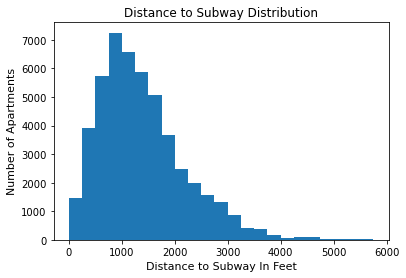

In [85]:
plt.figure()
# A block in NYC is about 250 feet
plt.hist(rent_df['min_dist_to_subway'], bins = range(0, 6000, 250))
plt.title('Distance to Subway Distribution',fontsize=12)
plt.xlabel('Distance to Subway In Feet',fontsize=11)
plt.ylabel('Number of Apartments',fontsize=11)
plt.show()

We see that most apartments are about 1000 feet (so 4 blocks) from a subway and the distribution looks pretty reasonable. There are some outliers above 4000 feet. Let's take a look at some of the rows with the highest values.

In [87]:
rent_df[rent_df['min_dist_to_subway'] > 10000]

,bathrooms,bedrooms,description,latitude,longitude,price,elevator,cats_allowed,hardwood_floors,dogs_allowed,...,zipcode_11581,zipcode_11691,zipcode_11692,zipcode_11694,zipcode_11780,zipcode_11937,zipcode_12094,zipcode_13166,zipcode_19355,min_dist_to_subway
60,1.0,2,Check Out This Lovely Apartment Locate...,40.7493,-73.7142,1900,0,0,0,0,...,0,0,0,0,0,0,0,0,0,33405.797214
127,2.0,3,"Feast Your Eyes On Fabulously 3 Br , 2...",40.7796,-73.7804,2000,0,1,0,1,...,0,0,0,0,0,0,0,0,0,21583.367066
159,1.0,1,"When you choose Infinity, you'll move into an ...",41.0412,-73.5400,2195,1,0,0,0,...,0,0,0,0,0,0,0,0,0,139473.959787
1236,1.0,0,,40.7291,-74.2224,695,0,0,0,0,...,0,0,0,0,0,0,0,0,0,62857.945814
2338,1.0,0,Large studio apartment available for i...,40.9154,-73.8901,1100,1,0,0,0,...,0,0,0,0,0,0,0,0,0,11964.128701
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
46475,1.0,1,Cute and sunny 1 bed. Well kept apartment with...,40.7902,-73.8659,1550,1,0,0,0,...,0,0,0,0,0,0,0,0,0,15531.603571
47197,2.0,2,Shown by appointment. Please contact call or g...,40.6379,-74.0759,2300,1,0,0,0,...,0,0,0,0,0,0,0,0,0,16204.862018
47629,1.0,2,PERFECT TWO BEDROOM APARTMENT!\r\rUNBEATABLE P...,40.7697,-73.7885,1800,0,0,0,0,...,0,0,0,0,0,0,0,0,0,15645.347066
48354,1.0,2,Check Out This Lovely Apartment Locate...,40.7493,-73.7142,1900,0,0,0,0,...,0,0,0,0,0,0,0,0,0,33405.797214


Through inspection, these look like apartments that are in NYC but are far from public transit. Let's create a new column to indicate for those over 4000 feet from a subway because they may be in areas where buses or cars are more frequently used, and may not mean that further distance is worse (since you don't use the subway). Then we may also create a feature that is the combination of the two.

In [101]:
rent_df["very_far_from_subway"] = rent_df['min_dist_to_subway'] > 4000
rent_df["very_far_from_subway"] = rent_df["very_far_from_subway"].astype("int64")

# This column will be the distnace to subway capped at 4000
rent_df["subway_distance_max_4000"] = rent_df['min_dist_to_subway'] * (rent_df['min_dist_to_subway'] < 4000) + 4000 * (rent_df['min_dist_to_subway'] >= 4000)
rent_df.head()

,bathrooms,bedrooms,description,latitude,longitude,price,elevator,cats_allowed,hardwood_floors,dogs_allowed,...,zipcode_11692,zipcode_11694,zipcode_11780,zipcode_11937,zipcode_12094,zipcode_13166,zipcode_19355,min_dist_to_subway,very_far_from_subway,subway_distance_max_4000
0,1.5,3,A Brand New 3 Bedroom 1.5 bath ApartmentEnjoy ...,40.7145,-73.9425,3000,0,0,0,0,...,0,0,0,0,0,0,0,443.823827,0,443.823827
1,1.0,2,,40.7947,-73.9667,5465,1,1,0,1,...,0,0,0,0,0,0,0,1726.069578,0,1726.069578
2,1.0,1,"Top Top West Village location, beautiful Pre-w...",40.7388,-74.0018,2850,0,0,1,0,...,0,0,0,0,0,0,0,579.726465,0,579.726465
3,1.0,1,Building Amenities - Garage - Garden - fitness...,40.7539,-73.9677,3275,0,0,1,0,...,0,0,0,0,0,0,0,1694.382496,0,1694.382496
4,1.0,4,Beautifully renovated 3 bedroom flex 4 bedroom...,40.8241,-73.9493,3350,0,0,0,0,...,0,0,0,0,0,0,0,1197.655516,0,1197.655516


We are done adding features and cleaning the data, let's save the data before proceeding.

In [116]:
rent_df.to_csv('data/clean_rent_data_pre_description.csv', index=False)

Let's load from our saved version below, so we may skip previous steps if needed (primarily zip code calculations are slow).

In [3]:
rent_df = pd.read_csv("data/clean_rent_data_pre_description.csv")
# Because of how pd saves CSVs, we have to fillna with empty string again
rent_df["description"] = rent_df["description"].fillna("")
rent_df.isna().sum()

bathrooms                   0
bedrooms                    0
description                 0
latitude                    0
longitude                   0
                           ..
zipcode_13166               0
zipcode_19355               0
min_dist_to_subway          0
very_far_from_subway        0
subway_distance_max_4000    0
Length: 233, dtype: int64

In [4]:
rent_df.head()

,bathrooms,bedrooms,description,latitude,longitude,price,elevator,cats_allowed,hardwood_floors,dogs_allowed,...,zipcode_11692,zipcode_11694,zipcode_11780,zipcode_11937,zipcode_12094,zipcode_13166,zipcode_19355,min_dist_to_subway,very_far_from_subway,subway_distance_max_4000
0,1.5,3,A Brand New 3 Bedroom 1.5 bath ApartmentEnjoy ...,40.7145,-73.9425,3000,0,0,0,0,...,0,0,0,0,0,0,0,443.823827,0,443.823827
1,1.0,2,,40.7947,-73.9667,5465,1,1,0,1,...,0,0,0,0,0,0,0,1726.069578,0,1726.069578
2,1.0,1,"Top Top West Village location, beautiful Pre-w...",40.7388,-74.0018,2850,0,0,1,0,...,0,0,0,0,0,0,0,579.726465,0,579.726465
3,1.0,1,Building Amenities - Garage - Garden - fitness...,40.7539,-73.9677,3275,0,0,1,0,...,0,0,0,0,0,0,0,1694.382496,0,1694.382496
4,1.0,4,Beautifully renovated 3 bedroom flex 4 bedroom...,40.8241,-73.9493,3350,0,0,0,0,...,0,0,0,0,0,0,0,1197.655516,0,1197.655516


In [5]:
rent_df.shape

(49292, 233)

## Train and Test Data

For the rest of the data analysis, we will be acting on the data based on information about its relation to each other, and in particular, price. Hence, we will now split the data into train and test data sets.

We will only investigate how changes may perform looking at the training data set, but we will apply any changes also to the test dataset.

In [8]:
from sklearn.model_selection import train_test_split

train_df, test_df = train_test_split(rent_df, test_size=.1)

In [9]:
# We reset the index because we later need to join in with the bag of words, which will be created from an array
# so the index needs to be reset to start from 0 to do that join properly
train_df = train_df.reset_index()
train_df = train_df.drop(columns=["index"])
test_df = test_df.reset_index()
test_df = test_df.drop(columns=["index"])

## High Level Overview

Let's get a high level overview of the data so far.
We can look at the correlation between price and any of the columns.

We will only look at the train_df.

In [10]:
pd.DataFrame(train_df.corr()['price'].sort_values(ascending=False)).style.background_gradient(cmap='coolwarm')


,price
price,1.000000
bathrooms,0.065081
bedrooms,0.049039
doorman,0.032940
zipcode_10012,0.030765
exclusive,0.024832
elevator,0.022951
laundry_in_unit,0.020709
dining_room,0.019624
zipcode_10019,0.015655


We see that no one factor impacts price very much, although number of bathrooms and bedrooms is the most indicative.

We see that laundry in building has a negative correlation - this may be because laundry_in_unit is a positive correlation. But we also saw above that laundry in building had few data points and may be inaccurate. Let us drop this column since we are suspect of it's quality.

We see that the subway_distance_max_4000 is negativelty correlated while min_dist_to_subway is positively correlated. This is probably because of the rental units that are very far from the subway may not necessarily be cheap because they may have access to cars or busses, so let's drop min_dist_to_subway. very_far_from_subway looks negatively correlated which makes sense.

In general we see that positive features for an apartment have correlation with price, which is expected, so this data makes sense so far.

We may also want to drop other columns that we are not sure are accurate or do not add much to the model, such as high_speed_internet, but for now we can leave them in. We may also want to drop zip codes that are very rare, but for now we leave them in.

In [11]:
train_df = train_df.drop(columns=["laundry_in_building", "min_dist_to_subway"])
test_df = test_df.drop(columns=["laundry_in_building", "min_dist_to_subway"])

### Description

Description is the listing description of the apartment. This presents two opportunities:
- We may find qualities of an apartment that may impact the price of an apartment. We may allow for the calculator to take in custom descriptions and if they are trained on from this field, may impact the price.
- We may find which qualities of an apartment should be listed on a listing to help market the apartment

Let us clean this data up and make a bag of words

In [12]:
import nltk

# Let's test it out
stemmer = nltk.stem.PorterStemmer()

In [14]:
from sklearn.feature_extraction.text import CountVectorizer
import re

X = train_df.drop(columns=["price"])
y = train_df["price"]

# We split the training set further into train and test sets just for bag of words
# We use a large test size in order to reduce computational costs
X_bag_train, X_bag_test, y_bag_train, y_bag_test = train_test_split(X, y, test_size=0.6)

# Through inspection, the description may have strange characters including HTML code. Try to remove these in a preprocessor
def preprocess_text(text):
    text = re.sub(r'[\+!~@#$%^&*()={}\[\]:;<.>?/\'"\\\r,]', "", text)
    return text

# Through inspection, the description may have some unique words that are not useful, remove those.
def custom_stem(word):
    # br is linebreak in html and should be ignored
    if word.replace("-", "") == "br":
        return ""
    # redacted is used in some of the descriptions due to renthop redacting data
    if "redact" in word.lower():
        return ""
    if len(word.replace("-", "")) < 2:
        return ""
    return stemmer.stem(word)

bagofwords = CountVectorizer(
    # preprocess the text to remove special characters
    preprocessor=preprocess_text,
    # Remove common english words
    stop_words="english",
    tokenizer=lambda x: [custom_stem(i) for i in x.split(" ")],
    # we set a pretty high minimum here because while trying to train basic models, we see that some
    # words that show up rarely may cause overfitting. This will also improve speed of the model calculations later
    # by adding fewer columns.
    min_df=100,
)

# 2. Fit
bagofwords.fit(X_bag_train["description"])

# 3. Transform
X_train_transformed = bagofwords.transform(X_bag_train["description"])
X_train_transformed


<17744x1000 sparse matrix of type '<class 'numpy.int64'>'
	with 738844 stored elements in Compressed Sparse Row format>

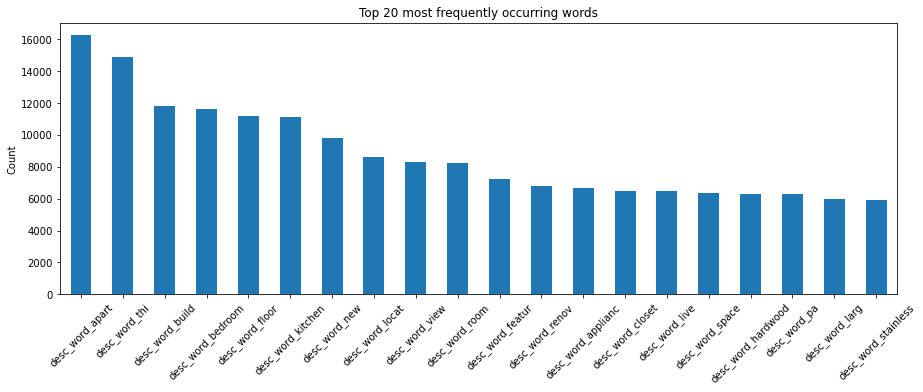

In [15]:
bow_column_names = ["desc_word_" + fn for fn in bagofwords.get_feature_names()]
word_counts = pd.DataFrame(
    {"counts": X_train_transformed.toarray().sum(axis=0)},
    index=bow_column_names
).sort_values("counts", ascending=False)

# Drop empty word
word_counts = word_counts.drop(["desc_word_"], axis=0)

word_counts.head(20).plot(kind="bar", figsize=(15, 5), legend=False)
plt.title("Top 20 most frequently occurring words")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.show()


In [16]:
X_train_new_df = pd.DataFrame(columns=bow_column_names, data=X_train_transformed.toarray())
display(X_train_new_df)

,desc_word_,desc_word_-------------list,desc_word_-disclosur,desc_word_000-420-2751,desc_word_10,desc_word_100,desc_word_1000,desc_word_11,desc_word_12,desc_word_123,...,desc_word_wrap,desc_word_wwwhgrnycomva,desc_word_wwwmironpropertiescompa,desc_word_xl,desc_word_yard,desc_word_year,desc_word_yoga,desc_word_york,desc_word_youll,desc_word_zack
0,13,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
1,10,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,7,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,11,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,8,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17739,6,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
17740,8,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
17741,13,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
17742,11,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0


This all makes sense, except there is an empty string column. Let's transform the full training set and full test set, then drop that column.

In [17]:
train_transformed = bagofwords.transform(train_df["description"])
test_transformed = bagofwords.transform(test_df["description"])

train_words_df = pd.DataFrame(columns=bow_column_names, data=train_transformed.toarray())
test_words_df = pd.DataFrame(columns=bow_column_names, data=test_transformed.toarray())

In [18]:
train_words_df = train_words_df.drop(columns=["desc_word_"])
test_words_df = test_words_df.drop(columns=["desc_word_"])

train_df = train_df.join(train_words_df)
test_df = test_df.join(test_words_df)

In [19]:
train_df.head()

,bathrooms,bedrooms,description,latitude,longitude,price,elevator,cats_allowed,hardwood_floors,dogs_allowed,...,desc_word_wrap,desc_word_wwwhgrnycomva,desc_word_wwwmironpropertiescompa,desc_word_xl,desc_word_yard,desc_word_year,desc_word_yoga,desc_word_york,desc_word_youll,desc_word_zack
0,1.0,2,HUGE KING SIZE 2BR PLUS SEPARATE DINING AREA! ...,40.7528,-73.9709,4050,1,0,1,0,...,0,0,0,0,0,0,0,0,0,0
1,1.0,1,No Brokers Fee + 1 Month Free * Rego Park's Ne...,40.7327,-73.8638,2375,1,1,1,1,...,0,0,0,0,0,0,1,0,0,0
2,2.0,2,Easily the best deal on the island!!! Prime Ha...,40.8275,-73.9456,2300,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
3,1.0,1,Not to be missed! BRAND NEW renovation!. Apart...,40.6748,-73.9809,2400,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1.0,2,- Renovated residence/luxury building<br> - Fl...,40.7032,-73.9914,4935,1,1,0,1,...,0,0,0,0,0,0,0,0,0,0


In [20]:
test_df.head()

,bathrooms,bedrooms,description,latitude,longitude,price,elevator,cats_allowed,hardwood_floors,dogs_allowed,...,desc_word_wrap,desc_word_wwwhgrnycomva,desc_word_wwwmironpropertiescompa,desc_word_xl,desc_word_yard,desc_word_year,desc_word_yoga,desc_word_york,desc_word_youll,desc_word_zack
0,1.0,1,Take advantage of this opportunity to rent a s...,40.7155,-74.0161,4300,1,1,0,1,...,0,0,0,0,0,0,0,0,0,0
1,2.0,3,***AMAZING LOCATION*** CENTRALLY LOCATED IN TH...,40.7399,-73.9864,5200,1,0,1,0,...,0,0,0,0,0,0,0,0,0,0
2,1.0,3,Location: Upper West Side\r\rLarge 3 bedroom a...,40.8021,-73.9670,2495,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1.0,1,Panoramic city views; the building stands in t...,40.7494,-73.9875,4700,1,0,0,0,...,0,0,0,0,0,0,0,1,0,0
4,1.0,2,"Newly Renovated: Immaculate, naturally well-li...",40.7987,-73.9610,3200,0,0,1,0,...,0,0,0,0,0,0,0,1,0,0


In [21]:
[
    train_df.shape,
    test_df.shape
]

[(44362, 1230), (4930, 1230)]

In [23]:
# Let's just check that it was joined properly, we see that renovat and bedroom appear in the corresponding descriptions
# and not in the other descriptions.
[
    train_df["desc_word_renov"].head(),
    train_df["desc_word_bedroom"].head(),
    train_df["description"][0],
    train_df["description"][1],
    train_df["description"][2],
    train_df["description"][3],
    train_df["description"][4]
]

[0    1
 1    0
 2    1
 3    1
 4    1
 Name: desc_word_renov, dtype: int64,
 0    0
 1    2
 2    2
 3    2
 4    0
 Name: desc_word_bedroom, dtype: int64,
 "HUGE KING SIZE 2BR PLUS SEPARATE DINING AREA! DOORMAN BUILDING RIGHT OF THIRD AVE/MID 40'S!STEP TO GRAND CENTRAL, FINE RESTAURANTS, BARS AND THE U.N!THIS UNIT IS NEWLY RENOVATED, NEW KITCHEN WITH NEW APPLIANCES, NEW MARBLE BATH & LARGE LIVING ROOM .DOORMAN BUILDING, LIVE-IN SUPER AND LAUNDRY ON-SITE.FOR INFO AND VIEWING, PLEASE CALL<br /><br />DORIN: 472-427-1421EMAIL: kagglemanager@renthop.com<br /><br /><br /><br /><br /><br /><br /><br /><p><a  website_redacted ",
 'No Brokers Fee + 1 Month Free * Rego Park\'s Newest Luxury Building * 1 Bedroom 1 Bathroom * Nearby M + R Trains + Rego Mall !In a culturally rich neighborhood with deep roots and hidden gems, the building is located in central Queens at Rego Center just steps to numerous subways and buses. This developing hub of arts, culture, dining and attractions is near the b

Let's save the new data frame including the bag of words into new CSV files.
We will save the test and train data separately so that when we calculate the model we use the same split.

In [24]:
train_df.to_csv('data/clean_rent_data_post_desc_train.csv', index=False)
test_df.to_csv('data/clean_rent_data_post_desc_test.csv', index=False)